# Game State
In this notebook I will explore setting up the game state, encoding the rules, and coming up with a way to determine all the possible moves given a game state and a dice roll. 

[This Repo](https://github.com/weekend37/Backgammon) contains python code that could be useful. 

One thing I really like about what they do is use negative numbers to represent the other play, instead of increasing the size of the array, so we would need 24 board spaces, two bar spaces, two end spaces, for a total of 28 spaces--I think we should do that

In [541]:
import numpy as np
import random

## Game State

In [435]:
state = np.zeros(28)

## Game Start
Places the pieces for the start of the game. I am going based on image in the repo, so I will cal player 1 blue, and player 2 red. 

In [436]:
def init_state():
    """
    Retruns a new game state array for the start of a game
    """
    state = np.zeros(28)
    
    # Place player one
    state[0] = 2
    state[11] = 5
    state[16] = 3
    state[18] = 5
    
    # Place player two
    state[5] = -5
    state[7] = -3
    state[12] = -5
    state[23] = -2
    
    return state

In [437]:
def pretty_print(board):
    """
    Prints a nicer version of the game state to look
    like the board
    """
    string = ""
    
    # Do the top of the board
    string += np.array2string(board[12:24]) + '\n'
    
    # Do the bottom of the board
    string += np.array2string(np.flip(board[0:12])) + '\n'
    
    # Show the bar
    string += 'Bar: ' + np.array2string(board[24:26]) + "\n"
    
    # Show the end
    string += 'End: ' + np.array2string(board[26:])
    
    print("Board:")
    print(string)

In [438]:
# Test it out
pretty_print(init_state())

Board:
[-5.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]


Now we need a way to update the game state, this will assume that the move being requested is legal. This function will take in the board, the position from which a chip is to be moved, and the position to which it is to be moved. 

In [744]:
def update_board(board, start, end):
    """
    Takes in a game state board array, the 
    index of a chip we would like to move, and
    the index of where we would like it to end up
    **This function does __not__ check if the 
    requested move is legal
    
    Returns the updated game state array
    """
    # Determine which player we are dealing with
    if (board[start] < 0):
        player = 'neg'
    elif (board[start] > 0):
        player = 'pos'
    else:
        raise ValueError("Moving from a place with no chips")
        
    
    # Update start and end positions
    if (player == 'pos'):
        board[start] -= 1
        
        # Check case we are sending a piece to the bar
        if (board[end] == -1):
            board[end] = 1
            board[25] -= 1
        else:
            # standard move
            board[end] += 1
            
    else:
        board[start] += 1
        
        # Check case we are sending piece to bar
        if (board[end] == 1):
            board[end] = -1
            board[24] += 1
        else:
            # standard move
            board[end] -= 1
        
    return board

# Moves
Gives a game state (assuming for now that we are always playing as player one ($>0$), how can we decide on what all our possible moves are given the dice roll.

In [440]:
def roll():
    """
    Returns dice roll values, will be an array of size either 2 or four
    indicating the number of moves that can be made (four if doubles)
    """
    # Roll
    roll = np.random.randint(1, 7, 2)
    
    # Check for doubles
    if (roll[0] == roll[1]):
        roll = np.concatenate([roll, roll])
    
    return roll

Now that we have available the number of moves, we need to figure out what can be done with them. Lets start by just taking a single number, i.e. the first dice number, and see if we can find the legal moves there. 

The first thing that will need to be checked is if there is a piece at the bar. If so, we need to try to move him in.

The other edge case is if the greatest position (again we are just thinking of playe 1) is in the last quadrant.

In [441]:
# Start a new game
board = init_state()

In [442]:
def flip_board(board):
    """
    Returns a copy of the game board with the points
    and values flipped to it always looks like player
    one is playing
    """
    idx = np.concatenate([np.arange(23, -1, -1), [24, 25, 26, 27]])
    copy = np.copy(board)
    copy = copy[idx]
    return copy

In [850]:
def flip_board(board):
	"""
	Returns a copy of the game board with the points
	and values flipped to it always looks like player
	one is playing
	"""
	# Copy the board
	copy = np.copy(board)

	# Swap playing spots
	idx = np.concatenate([np.arange(23, -1, -1), [24, 25, 26, 27]])
	copy = copy[idx]

	# Swap bar and end
	idx = np.concatenate([np.arange(0, 24, 1), [25, 24, 27, 26]])
	copy = copy[idx]

	# Change signs
	copy = -1 * copy

	return copy

In [861]:
def flip_moves(moves):
	"""
	Flips the moves that are otherwise from the perspective
	of player 1 to player 2
	Swaps the bar and end spaces
	"""
	# print("Moves to flip", moves)
	new_moves = []
	for m in moves:
		move = []
		for p in m:
			# If normal game play space
			if (p <= 23):
				p1 = 23 - p
			# Special space, so swap it
			else:
				if (p == 24):
					p1 = 25
				elif (p == 25):
					p1 = 24
				elif (p == 26):
					p1 = 27
				else:
					p1 = 27

			move.append(p1)

		new_moves.append(move)
	return new_moves

In [960]:
def get_possible_moves(board, val, player):
    """
    Returns an array of tuples that are the possible moves
    for player 1 based on a given game board and
    the roll of a single value
    """
    # Copy the board
    bc = np.copy(board)

    # Set the board constants
    last_quad_start = 18
    bar = 24
    end_holder = 26

    if (player == "player 2"):
        bc = flip_board(bc)
#         print("Flipped Board")
#         pretty_print(bc)

    # Initialize move tracker
    possible_moves = []

    # Check if at the bar
    if (bc[bar] > 0):
#         print("got one at the bar")
#         print(bc[val-1])
        if bc[val-1] >= -1:
            possible_moves.append([bar, val-1])

    # None at the bar
    else:
        # get our inds
        our_inds = np.where(bc[0:24] > 0)[0] # as we don't want to consider end game state
        if (len(our_inds) == 0):
            return possible_moves

        # Check if last quadrant
        if (np.min(our_inds) >= last_quad_start):
            last_quad = True
        else:
            last_quad = False

        # Check possible chips to move
        for ind in our_inds:
            if (ind + val < 24): # note, other player moves in other direciton
                # legal, non chip removal move
                if (bc[ind + val] >= -1):
                    possible_moves.append([ind, ind+val])
            else:
                if (last_quad):
                    # then we can remove this piece
                    possible_moves.append([ind, end_holder])

    # Check if we need to flip the moves
    if (player == "player 2"):
#         print("Pre flipped moves:", possible_moves)
        possible_moves = flip_moves(possible_moves)

    return possible_moves


In [961]:
get_possible_moves(b, 4, "player 2")

[]

### Test Cases

In [863]:
def check_moves(m1,  m2):
    """
    Takes in two move arrays and 
    returns if they are the same or not
    """
    if (len(m1) != len(m2)):
        return False
    for m in m1:
        if not (m in m2):
            return False
    return True

In [864]:
# Test someone at the bar
board = init_state()
board[24] = 1
moves = get_possible_moves(board, 1, "player 1")
assert(moves == [[24, 0]])

In [865]:
# Test Standard move
board = init_state()
moves = get_possible_moves(board, 1, "player 1")
assert(check_moves(moves, [[0, 1], [16, 17], [18, 19]]))

In [866]:
# Test Bigger move
board = init_state()
moves = get_possible_moves(board, 5, "player 1")
assert(check_moves(moves, [[11, 16], [16, 21]]))

In [867]:
# Test most in last quadrant except one
board = init_state()
board[0] = 0
board[11] = 0
board[16] = 1
board[18] = 0
board[19] = 5
board[20] = 5
moves = get_possible_moves(board, 6, "player 1")
print(moves)
assert(check_moves(moves, [[16, 22]]))

[[16, 22]]


In [868]:
# Test all in last quadrant, ready to move
board = init_state()
board[0] = 0
board[11] = 0
board[16] = 0
board[18] = 0
board[22] = 5
moves = get_possible_moves(board, 2, "player 1")
print(moves)
assert(check_moves(moves, [[22, 26]]))

[[22, 26]]


In [869]:
# Another end state test with bigger roll
board = init_state()
board[0] = 0
board[11] = 0
board[16] = 0
board[18] = 0
board[22] = 5
moves = get_possible_moves(board, 5, "player 1")
print(moves)
assert(check_moves(moves, [[22, 26]]))

[[22, 26]]


In [870]:
# Test allowed to send an opponent to bar
board = init_state()
board[5] = -1
moves = get_possible_moves(board, 5, "player 1")
print(moves)
assert(check_moves(moves, [[0, 5], [11, 16], [16, 21]]))

[[0, 5], [11, 16], [16, 21]]


#### Do some test for player 2

In [871]:
# Test standard player two move
board = init_state()
moves = get_possible_moves(board, 3, "player 2")
print(moves)
assert(check_moves(moves, [[23, 20], [12, 9], [7, 4], [5, 2]]))

[[23, 20], [12, 9], [7, 4], [5, 2]]


In [874]:
# Test someone at the bar
board = init_state()
board[25] = -1
moves = get_possible_moves(board, 1, "player 2")
print(moves)
print(flip_moves(moves))
assert(moves == [[25, 23]])

[[25, 23]]
[[24, 0]]


In [876]:
# Case when there are no possible moves for player 2
board = init_state()
board[23] = 0
board[12] = 0
# board[5] = 0
board[7] = 0
moves = get_possible_moves(board, 5, "player 2")
print(moves)
assert(moves == [])

[]


In [877]:
# Player 2 end game affirmative
board = init_state()
board[23] = 0
board[12] = 0
# board[5] = 0
board[7] = 0
moves = get_possible_moves(board, 6, "player 2")
print(moves)
assert(check_moves(moves, [[5, 27]]))

[[5, 27]]


In [878]:
# Player 2 end game negative, but close
board = init_state()
board[23] = -1
board[22] = 0
board[12] = 0
# board[5] = 0
board[7] = 0
moves = get_possible_moves(board, 6, "player 2")
print(moves)
assert(check_moves(moves, [[23, 17]]))

[[23, 17]]


In [879]:
# Player 2, but game is already over
board = init_state()
board[5] = 0
board[7] = 0
board[12] = 0
board[23] = 0
board[27] = -15
moves = get_possible_moves(board, 3, "player 2")
assert(check_moves(moves, []))

In [880]:
get_all_moves(board, [2,3], "player 2")

[]

## Add in the second dice!
Now we need the logic to get all possible moves when there are two dice at play, and the possibility of rolling doubles, which means you get four total values. What are the scenarios we have to consider. First, most basic, that we get two distinct numbers, next we need to consider if we get doubles. 

First case, we want to consider using val 1 then val 2, and val 2 then val 1. In the doubles case we just need to get the four sequentials

In [881]:
def get_all_moves(board, vals, player):
    """
    Takes in a game board, the dice array
    and a string indicating which player we are dealign with
    and returns an array of the possible moves
    """
    # Initialize move tracker
    moves = []
    
    # If not doubles
    if (len(vals) == 2):
        # Try val 1 then val 2-----------------------------------------------------
        possible_first_moves = get_possible_moves(board, vals[0], player)

        # For each of the possible first moves, get the seoncd
        for m in possible_first_moves:
            # Get the new board state
            tmp_board = np.copy(board)
            tmp_board = update_board(tmp_board, m[0], m[1])
            possible_second_moves = get_possible_moves(tmp_board, vals[1], player)

            # Keep track of each of the second state moves
            if (len(possible_second_moves) == 0): moves.append([m]) # in case no second move
            for m2 in possible_second_moves:
                moves.append([m, m2])

        # Try val 2 then val 1-----------------------------------------------------
        possible_first_moves = get_possible_moves(board, vals[1], player)

        for m in possible_first_moves:
            # Get the new board state
            tmp_board = np.copy(board)
            tmp_board = update_board(tmp_board, m[0], m[1])
            possible_second_moves = get_possible_moves(tmp_board, vals[0], player)

            # Keep track of each of the second state moves
            if (len(possible_second_moves) == 0): moves.append([m]) # in case no second move
            for m2 in possible_second_moves:
                moves.append([m, m2])

    # Else, is doubles
    else:
        for m in get_possible_moves(board, vals[0], player):
            tb1 = update_board(np.copy(board), m[0], m[1])
            second_moves = get_possible_moves(tb1, vals[1], player)
            if (len(second_moves) == 0): moves.append([m])
            
            for m2 in second_moves:
                tb2 = update_board(np.copy(tb1), m2[0], m2[1])
                third_moves = get_possible_moves(np.copy(tb2), vals[2], player)
                if (len(third_moves) == 0): moves.append([m, m2])
                
                for m3 in third_moves:
                    tb3 = update_board(np.copy(tb2), m3[0], m3[1])
                    fourth_moves = get_possible_moves(np.copy(tb3), vals[3], player)
                    if (len(fourth_moves) == 0): moves.append([m, m2, m3])
                    
                    for m4 in fourth_moves:
                        moves.append([m, m2, m3, m4]) 
                        
    return moves

In [882]:
get_all_moves(b, vals, 'player 2')

[[[3, 0], [2, 0]],
 [[3, 0], [1, 27]],
 [[3, 0], [0, 27]],
 [[2, 27], [3, 1]],
 [[2, 27], [1, 27]],
 [[1, 27], [3, 1]],
 [[1, 27], [2, 0]],
 [[1, 27], [1, 27]],
 [[3, 1], [2, 27]],
 [[3, 1], [1, 27]],
 [[2, 0], [3, 0]],
 [[2, 0], [1, 27]],
 [[2, 0], [0, 27]],
 [[1, 27], [3, 0]],
 [[1, 27], [2, 27]],
 [[1, 27], [1, 27]]]

In [883]:
pretty_print(b)

Board:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -4.  0.]
Bar: [0. 0.]
End: [15. -9.]


# Play a Game!
There is one last thing we need to be able to do before we can play a game. We need to be able to update the board with multiple moves at a time. I.e., give a board, an move list, and then get the new board back.

Once we have that we have all the mechanics for a game, the last big barrier will be to determien when the game is actually finished

In [884]:
def update_by_moves(board, moves):
    """
    Takes in a board an a list of moves, and returns
    the updated version of the board
    """
    # Copy the board
    board = np.copy(board)
    
    # For each move, update board
    for m in moves:
        board = update_board(board, m[0], m[1])
        
    return board

Before we play a game we need the concept of a player. Something that will look at the board the dice rolled and decide what to do next. For now, we will make a naive player that makes random, legal, moves

In [885]:
class Player(object):
    def __init__(self, which):
        # player 1 or player 2
        self.which = which
        
    def __str__(self):
        return self.which
    
    def __repr__(self):
        return self.which
        
    def action(self, board, vals):
        """
        Takes in the board state and the value of the
        dice rolled, and returns the desired move
        """
        # get all the moves
        all_moves = get_all_moves(board, vals, self.which)
        
        # Randomly pick one
        if (len(all_moves) == 0):
            move = []
        else:
            move = random.choice(all_moves)
        
        return move

Now we can play the game with two random players. 

In [886]:
def play_game(p1, p2):
    """
    Runs through a game with the given players
    Returns the player who won
    
    At some point, for training, we are going to have to figure out
    if we wnat to keep track of the boards
    that each player saw individually
    """
    # Initialize a board
    board = init_state()
    board_tracker = [board] # list of boards

    # Initialize players
    # p1 = Player("player 1")
    # p2 = Player("player 2")

    # Roll the first to decide who goes first
    not_same = True
    while not_same:
        vals = roll()
        not_same = True if (len(vals) != 2) else False

    if (vals[0] > vals[1]):
        player = p1
    else:
        player = p2

    # Game loop
    game_over = False
    i = 0
    while not game_over:
        i += 1

        # Get players move
        next_move = player.action(board, vals)

        # Update the board
        board = update_by_moves(board, next_move)
        board_tracker.append(board)

        # Roll the dice
        vals = roll()

        # Switch player
        player = p2 if (player == p1) else p1

        # Check if the game is over
        if (board[26] >= 15. or board[27] <= -15.):
            game_over = True

        if (i >= 10000):
            print("PROBLEM")
            game_over = True
        
    # Now that the game is over determine the winner
    winner = p1 if (board[26] == 15) else p2
    obj = {'winner': winner, 'turns': i}
    
    return obj

In [964]:
np.random.seed(0)

p1 = Player("player 1")
p2 = Player("player 2")

# Initialize a board
board = init_state()
board_tracker = [board] # list of boards
roll_tracker = []
move_tracker = []

not_same = True
while not_same:
    vals = roll()
    not_same = True if (len(vals) != 2) else False

if (vals[0] > vals[1]):
    starting_player = p1
    player = p1
else:
    starting_player = p2
    player = p2

roll_tracker.append(vals)

# Game loop
game_over = False
i = 0
while not game_over:
    i += 1

    # Get players move
    next_move = player.action(board, vals)
    move_tracker.append(next_move)

    # Update the board
    board = update_by_moves(board, next_move)
    board_tracker.append(board)

    # Roll the dice
    vals = roll()
    roll_tracker.append(vals)

    # Switch player
    player = p2 if (player == p1) else p1

    # Check if the game is over
    if (board[26] >= 15. or board[27] <= -15.):
        game_over = True


    if (i >= 10000):
        print("PROBLEM")
        game_over = True

# Now that the game is over determine the winner
winner = p1 if (board[26] == 15) else p2
obj = {'winner': winner, 'turns': i, 'starting_player':starting_player, "rolls": roll_tracker}

# print(obj)
print(winner)
print("turns", i)
print(starting_player)

player 2
turns 51
player 2


In [929]:
i = 34
b = board_tracker[i]
print("i:", i)
print("p1 sum:", b[np.where(b > 0)].sum())
print("p2 sum:", b[np.where(b < 0)].sum())
print("move:", move_tracker[i])
print("Roll:", roll_tracker[i])
pretty_print(b)
print("-"*30)

i += 1
b = board_tracker[i]
print("i:", i)
print("p1 sum:", b[np.where(b > 0)].sum())
print("p2 sum:", b[np.where(b < 0)].sum())
print("move:", move_tracker[i])
print("Roll:", roll_tracker[i])
pretty_print(b)
print("-"*30)

i: 34
p1 sum: 15.0
p2 sum: -15.0
move: [[25, 20], [17, 14]]
Roll: [3 4]
Board:
[ 1.  2.  0.  0.  0. -3.  2.  0.  2.  0.  5. -1.]
[ 0.  0.  0.  0.  1.  0. -4.  0.  0.  2. -6.  0.]
Bar: [ 0. -1.]
End: [0. 0.]
------------------------------
i: 35
p1 sum: 14.0
p2 sum: -14.0
move: [[7, 11], [2, 3]]
Roll: [1 4]
Board:
[ 1.  2. -1.  0.  0. -2.  2.  0.  1.  0.  5. -1.]
[ 0.  0.  0.  0.  1.  0. -4.  0.  0.  2. -6.  0.]
Bar: [0. 0.]
End: [0. 0.]
------------------------------


In [935]:
b = np.copy(board_tracker[34])

In [936]:
get_possible_moves(b, 4, "player 2")

[[25, 20]]

In [959]:
get_all_moves(b, [4, 6], "player 2")

Flipped Board
Board:
[-0. -0. -0. -0. -1. -0.  4. -0. -0. -2.  6. -0.]
[-1. -2. -0. -0. -0.  3. -2. -0. -2. -0. -5.  1.]
Bar: [ 1. -0.]
End: [-0. -0.]
got one at the bar
-2.0
Pre flipped moves: []
Flipped Board
Board:
[-0. -0. -0. -0. -1. -0.  4. -0. -0. -2.  6. -0.]
[-1. -2. -0. -0. -0.  3. -2. -0. -2. -0. -5.  1.]
Bar: [ 1. -0.]
End: [-0. -0.]
got one at the bar
-2.0
Pre flipped moves: []


[]

In [928]:
for i in range(50):
    b = board_tracker[i]
    print("i:", i)
    print("p1 sum:", b[np.where(b > 0)].sum())
    print("p2 sum:", b[np.where(b < 0)].sum())
    print("Move:", move_tracker[i])
    print("Roll:", roll_tracker[i])
    pretty_print(b)
    print("-"*30)

i: 0
p1 sum: 15.0
p2 sum: -15.0
Move: [[7, 1], [12, 7]]
Roll: [5 6]
Board:
[-5.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]
------------------------------
i: 1
p1 sum: 15.0
p2 sum: -15.0
Move: [[16, 20], [20, 21]]
Roll: [1 4]
Board:
[-4.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0. -1.  2.]
Bar: [0. 0.]
End: [0. 0.]
------------------------------
i: 2
p1 sum: 15.0
p2 sum: -15.0
Move: [[5, 1], [23, 19], [5, 1], [23, 19]]
Roll: [4 4 4 4]
Board:
[-4.  0.  0.  0.  2.  0.  5.  0.  0.  1.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0. -1.  2.]
Bar: [0. 0.]
End: [0. 0.]
------------------------------
i: 3
p1 sum: 15.0
p2 sum: -15.0
Move: [[18, 20], [18, 22]]
Roll: [2 4]
Board:
[-4.  0.  0.  0.  2.  0.  5. -2.  0.  1.  0.  0.]
[ 5.  0.  0.  0. -3.  0. -3.  0.  0.  0. -3.  2.]
Bar: [0. 0.]
End: [0. 0.]
------------------------------
i: 4
p1 sum: 15.0
p2 sum: -15.0
Move: [[7, 

In [826]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [828]:
# Run a bunch of times
N = 1000
p1 = Player("player 1")
p2 = Player("player 2")
counts = np.zeros(N)

for i in tqdm(range(N)):
    # Run the game
    out = play_game(p1, p2)
    counts[i] = out['turns']

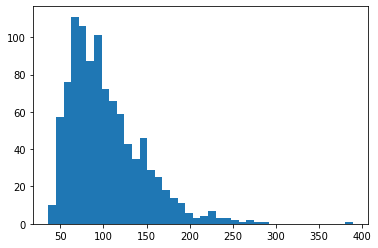

In [831]:
# plot the results
plt.hist(counts, bins=40)
plt.show()

In [829]:
%%timeit
# How long does it actually take
out = play_game(p1, p2)

66.5 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [832]:
np.arange(0, 24, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [820]:
# Initialize a board
board = init_state()
board_tracker = [board] # list of boards

# Initialize players
p1 = Player("player 1")
p2 = Player("player 2")

# Roll the first to decide who goes first
not_same = True
while not_same:
    vals = roll()
    not_same = True if (len(vals) != 2) else False

if (vals[0] > vals[1]):
    player = p1
else:
    player = p2
    
# Game loop
game_over = False
i = 0
while not game_over:
    i += 1
    
    # Get players move
    next_move = player.action(board, vals)
    
    # Update the board
    board = update_by_moves(board, next_move)
    board_tracker.append(board)
    
    # Roll the dice
    vals = roll()
    
    # Switch player
    player = p2 if (player == p1) else p1
    
    # Check if the game is over
    if (board[26] >= 15. or board[27] <= -15.):
        game_over = True
        
    if (i >= 10000):
        print("PROBLEM")
        game_over = True
        
print("Number of turns:", i)
print("Winner: ", player)

Number of turns: 136
Winner:  player 1


In [819]:
b = board_tracker[-1]
pretty_print(b)

Board:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -4.  0.]
Bar: [0. 0.]
End: [15. -9.]


In [779]:
vals

array([5, 3])

In [780]:
get_all_moves(b, vals, 'player 2')

[]

In [778]:
get_possible_moves(b, 1, 'player 2')

[[0, 27]]

In [719]:
for board in board_tracker:
    pretty_print(board)
    print("-"*20)

Board:
[-5.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]
--------------------
Board:
[-4.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0. -1. -2.  0. -5.  0.  0. -1.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]
--------------------
Board:
[-4.  0.  0.  0.  1.  0.  5.  0.  0.  3.  0. -2.]
[ 4.  0.  0. -1. -2.  0. -5.  0.  0. -1.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]
--------------------
Board:
[-3.  0.  0.  0.  1.  0.  5.  0.  0.  3.  0. -2.]
[ 4.  0.  0. -1. -2.  0. -5.  0.  0. -2.  0.  2.]
Bar: [0. 0.]
End: [0. 0.]
--------------------
Board:
[-3.  0.  2.  0.  0.  0.  5.  1.  0.  3.  0. -2.]
[ 2.  0.  0. -1. -2.  0. -5.  0.  1. -2.  0.  1.]
Bar: [0. 0.]
End: [0. 0.]
--------------------
Board:
[-2.  0.  2.  0.  0.  0.  5.  1.  0.  3.  0. -2.]
[ 2.  0.  0. -1. -1. -1. -6.  0.  1. -2.  0.  1.]
Bar: [0. 0.]
End: [0. 0.]
--------------------
Board:
[-2.  0.  1.  0.  0.  0.  5.  1.  1.  3.  0. -2.]
[ 2.  0.  0. -1. -1

---
## Scratch

In [147]:
# Focus on one number
val = roll()[0]
print(val)

4


In [148]:
# Force val
val = 1

In [169]:
# Place one at the bar
board[24] = 1

How to check for moves?
- Check if at the bar
- If not at the bar
    - get furtherst back index and make boolean if all in last quadrant
    - Get indicies of all postive chips
    - for each index
        - if index + roll < end board index
            - check if board[index + roll] is >= -1
                - If so, add move to move list
        - Else 
            - if last quadrant tracker is true
                - add move ending in end board position for this player
                
At some point I need to be checking if the game is over?

In [170]:
np.where(board > 0)

(array([ 0, 11, 16, 18, 24]),)

In [162]:
# Setup Constants 
last_quad_start = 18
bar = 24
end_holder = 26

In [178]:
# Roll
# val = roll()[0]
val = 6

# Initialize move tracker
possible_moves = []

# Check if at the bar
if (board[bar] > 0):
    print("have bar")
    print(board[val-1])
    if board[val-1] >= -1:
        possible_moves.append([bar, val])

# None at the bar
else:
    # get our inds
    our_inds = np.where(board[0:24] > 0)[0] # as we don't want to consider end game state
    
    # Check if last quadrant
    if (np.min(our_inds) >= last_quad_start):
        last_quad = True
    else:
        last_quad = False
        
    # Check possible chips to move
    for ind in our_inds:
        if (ind + val < 24): # note, other player moves in other direciton
            # legal, non chip removal move
            if (board[ind + val] >= -1):
                possible_moves.append([ind, ind+val])
        else:
            if (last_quad):
                # then we can remove this piece
                possible_moves.append([ind, end_holder])
    
print("Roll:", val)
print("Possible moves:", possible_moves)
pretty_print(board)

have bar
-5.0
Roll: 6
Possible moves: []
Board:
[-5.  0.  0.  0.  3.  0.  5.  0.  0.  0.  0. -2.]
[ 5.  0.  0.  0. -3.  0. -5.  0.  0.  0.  0.  2.]
Bar: [1. 0.]
End: [0. 0.]
